<a href="https://colab.research.google.com/github/oscarB1nar10/SelfDrivingCar/blob/main/sdc_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Setup
#### 1.1 Libraries




In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import random
import csv
from PIL import Image
import os
import datetime
import pickle
import threading
import cv2
import shutil
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline
from random import seed
from sklearn.model_selection import train_test_split
from multiprocessing import Pool, set_start_method

# # Tensorflow
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKerasTF # pip install livelossplot
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.layers import TimeDistributed, LSTM

# # Sklearn
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'livelossplot'

In [ ]:
#!pip install PyDrive
#!pip install opencv-python-headless
#!pip install tensorflow
!pip install livelossplot
#!pip uninstall pillow|
#!pip install pillow-simd
##pip install jupyter_http_over_ws

In [ ]:
# Mount Google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### 1.2 Paths

In [ ]:
# Images path
right_images = '/content/drive/MyDrive/ML/sdc/data_for_training/data/right'
left_images = '/content/drive/MyDrive/ML/sdc/data_for_training/data/left'
forward_images = '/content/drive/MyDrive/ML/sdc/data_for_training/data/forward'
backward_images = '/content/drive/MyDrive/ML/sdc/data_for_training/data/backward'
join_images = '/content/drive/MyDrive/ML/sdc/data_for_training/data/imgs_train'
# Log file path
log_file = '/content/drive/MyDrive/ML/sdc/data_for_training/data/log_test.csv'
model_path = '/content/drive/MyDrive/ML/sdc/trained_model/end_to_end.keras'

### 2. Data Cleaning

#### 2.1 Identity Corrupt Images

In [ ]:
# Get the number of images for folder
total_images = 0
def get_image_count(folder_path):
  global total_images
  image_count = 0
  for filename in os.listdir(folder_path):
    if filename.endswith(('jpg')):
      image_count += 1
      total_images += 1
  return image_count

print(f"Num of images in the right folder: {get_image_count(right_images)}")
print(f"Num of images in the left folder: {get_image_count(left_images)}")
print(f"Num of images in the forward folder: {get_image_count(forward_images)}")
#print(f"Num of images in the backward folder: {get_image_count(backward_images)}")
print(f"Total num of images: {total_images}")

Num of images in the right folder: 2045
Num of images in the left folder: 1985
Num of images in the forward folder: 8587
Total num of images: 12617


In [ ]:
# Remove corrupted images and capture its names to remove from the log file also
images_removed = []

def remove_corrupt_images(folder_path):
    image_number = 0
    removed_count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(('jpg')):  # Add any other image formats you expect
            image_number += 1
            try:
                with Image.open(os.path.join(folder_path, filename)) as img:
                    img.verify()  # Verify that it is, indeed, an image
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupt image: {filename}")
                os.remove(os.path.join(folder_path, filename))
                images_removed.append(filename)
                removed_count += 1

        if image_number % 100 == 0:
          print(image_number)

    print(f"Total corrupt images removed: {removed_count}")


In [ ]:
# Remove corrupt images from all paths
remove_corrupt_images(right_images)
remove_corrupt_images(left_images)
remove_corrupt_images(forward_images)
#remove_corrupt_images(backward_images)
#remove_corrupt_images(join_images)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Total corrupt images removed: 0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Total corrupt images removed: 0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
Total corrupt images removed: 0


#### 2.2 Remove Irrelevant Images

In [ ]:
def remove_blurry_images(folder_path, threshold=150):
  image_number = 0
  removed_count = 0
  for filename in os.listdir(folder_path):
    if filename.endswith(('png')):
      image_path = os.path.join(folder_path, filename)
      image = cv2.imread(image_path)
      if image is not None:
        image_number += 1
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # The Laplaciant operator is applied to the grayscale image. This operator calculates
        # the second derivatives of the image, which highlights areas of rapud intensity change (edges)
        # The variance 'var()' measures the spread of the edge responses generated by the Laplacian
        # operator. Higher variance indicates more edges and this less blurriness, while lower variance
        # suggests fewer edges and more blurriness
        focus_measure = cv2.Laplacian(gray, cv2.CV_64F).var()
        if focus_measure < threshold:
          print(f"Removing blurry image: {filename}")
          os.remove(image_path)
          images_removed.append(filename)
          removed_count += 1

        if image_number % 100 == 0:
          print(image_number)

  print(f"Total blurry images removed: {removed_count}")

In [ ]:
# Remove blurry images
remove_blurry_images(right_images)
remove_blurry_images(left_images)
remove_blurry_images(forward_images)

Total blurry images removed: 0
Total blurry images removed: 0
Total blurry images removed: 0


In [ ]:
# Remove log data that belong to corrupted images and blurry images previously removed

# Load your CSV file
df = pd.read_csv(log_file)

for image in images_removed:
  # check if the df['frameName'] contains the image if so then remove the row
  df = df[~df['frameName'].str.contains(image)]

# Save the updated DataFrame back to the CSV file
df.to_csv(log_file, index=False)

#### 2.3 Remove Orphaned Images

In [ ]:
# Remove images from folder
def remove_orphaned_images(folder_path, log_file):
  # Read the log file as a dataframe
  df = pd.read_csv(log_file)
  labeled_images = set(df.iloc[:, 0]) # Assuming image names are in the first column

  # List all images in the folder path
  all_images = set(os.listdir(folder_path))

  # Determine which images are not referenced in the dataframe
  orphaned_images = all_images - labeled_images
  for img in orphaned_images:
    os.remove(os.path.join(folder_path, img))
    print(f"Removed orphan image: {img}")

  print(f"Total orphan images removed: {len(orphaned_images)}")

In [ ]:
remove_orphaned_images(right_images, log_file)
remove_orphaned_images(left_images, log_file)
remove_orphaned_images(forward_images, log_file)
#remove_orphaned_images(backward_images, log_file)
#remove_orphaned_images(join_images, log_file)

Total orphan images removed: 0
Total orphan images removed: 0
Total orphan images removed: 0


### 2.4 Remove log row if image in 'frameName' does not exist

In [ ]:
df = pd.read_csv(log_file)

# Define the directories where your images are stored
image_directories = [
    right_images,
    left_images,
    forward_images,
    backward_images,
    join_images
]

# Function to check if the image exists in any of the directories
def image_exists(filename):
    return any(os.path.exists(os.path.join(dir, filename)) for dir in image_directories)

# Filter out rows where the image file does not exist in any of the directories
df = df[df['frameName'].apply(image_exists)]

# Optionally, save the updated DataFrame back to the CSV
df.to_csv(log_file, index=False)

#### 2.5 Gather all images into a Single folder

In [ ]:
def gather_images(source_folders, target_folder):
  os.makedirs(target_folder, exist_ok=True) # Create target folder if it does not exist
  for folder in source_folders:
    for filename in os.listdir(folder):
      if filename.endswith(('jpg')):
        source_path = os.path.join(folder, filename)
        target_path = os.path.join(target_folder, filename)
        shutil.copyfile(source_path, target_path) # Copy images

  print(f"Total images gathered: {len(os.listdir(target_folder))}")

source_folders = [right_images, left_images, forward_images]
gather_images(source_folders, join_images)

Total images gathered: 12617


#### 2.6 Resize images

In [ ]:
# imgs_train_path = '/content/drive/MyDrive/ML/sdc/data/imgs_train'
# # Directory to save the resized images
# output_folder = '/content/drive/MyDrive/ML/sdc/data/resized_imgs'

# # Desired size
# target_size = (200, 66)

# # Ensure the output directory exists, create if it doesn't
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Iterate over all files in the directory
# for filename in os.listdir(imgs_train_path):
#     if filename.lower().endswith('.png'):  # Only process PNG files
#         img_path = os.path.join(imgs_train_path, filename)
#         with Image.open(img_path) as img:
#             # Check if current size matches the target size or if image is RGBA
#             if img.size != target_size or img.mode == 'RGBA':
#                 # Resize the image
#                 img = img.resize(target_size)

#                 # Convert to RGB if it's RGBA
#                 if img.mode == 'RGBA':
#                     img = img.convert('RGB')

#                 # Change file extension to .jpg
#                 new_filename = filename[:-4] + '.jpg'
#                 new_img_path = os.path.join(output_folder, new_filename)

#                 # Save the image as JPEG
#                 img.save(new_img_path, 'JPEG', quality=90)  # Consider using quality 90 to reduce file size
#                 print(f'Converted and saved {new_filename}')

In [ ]:
# # Rename the 'frameName' in 'log_test' replacing the extension ".png" for ".jpg"
# df = pd.read_csv(log_file)
# df['frameName'] = df['frameName'].apply(lambda x: str(x).replace('.png', '.jpg'))
# df.to_csv(log_file, index=False)

### 3. Visualizing data

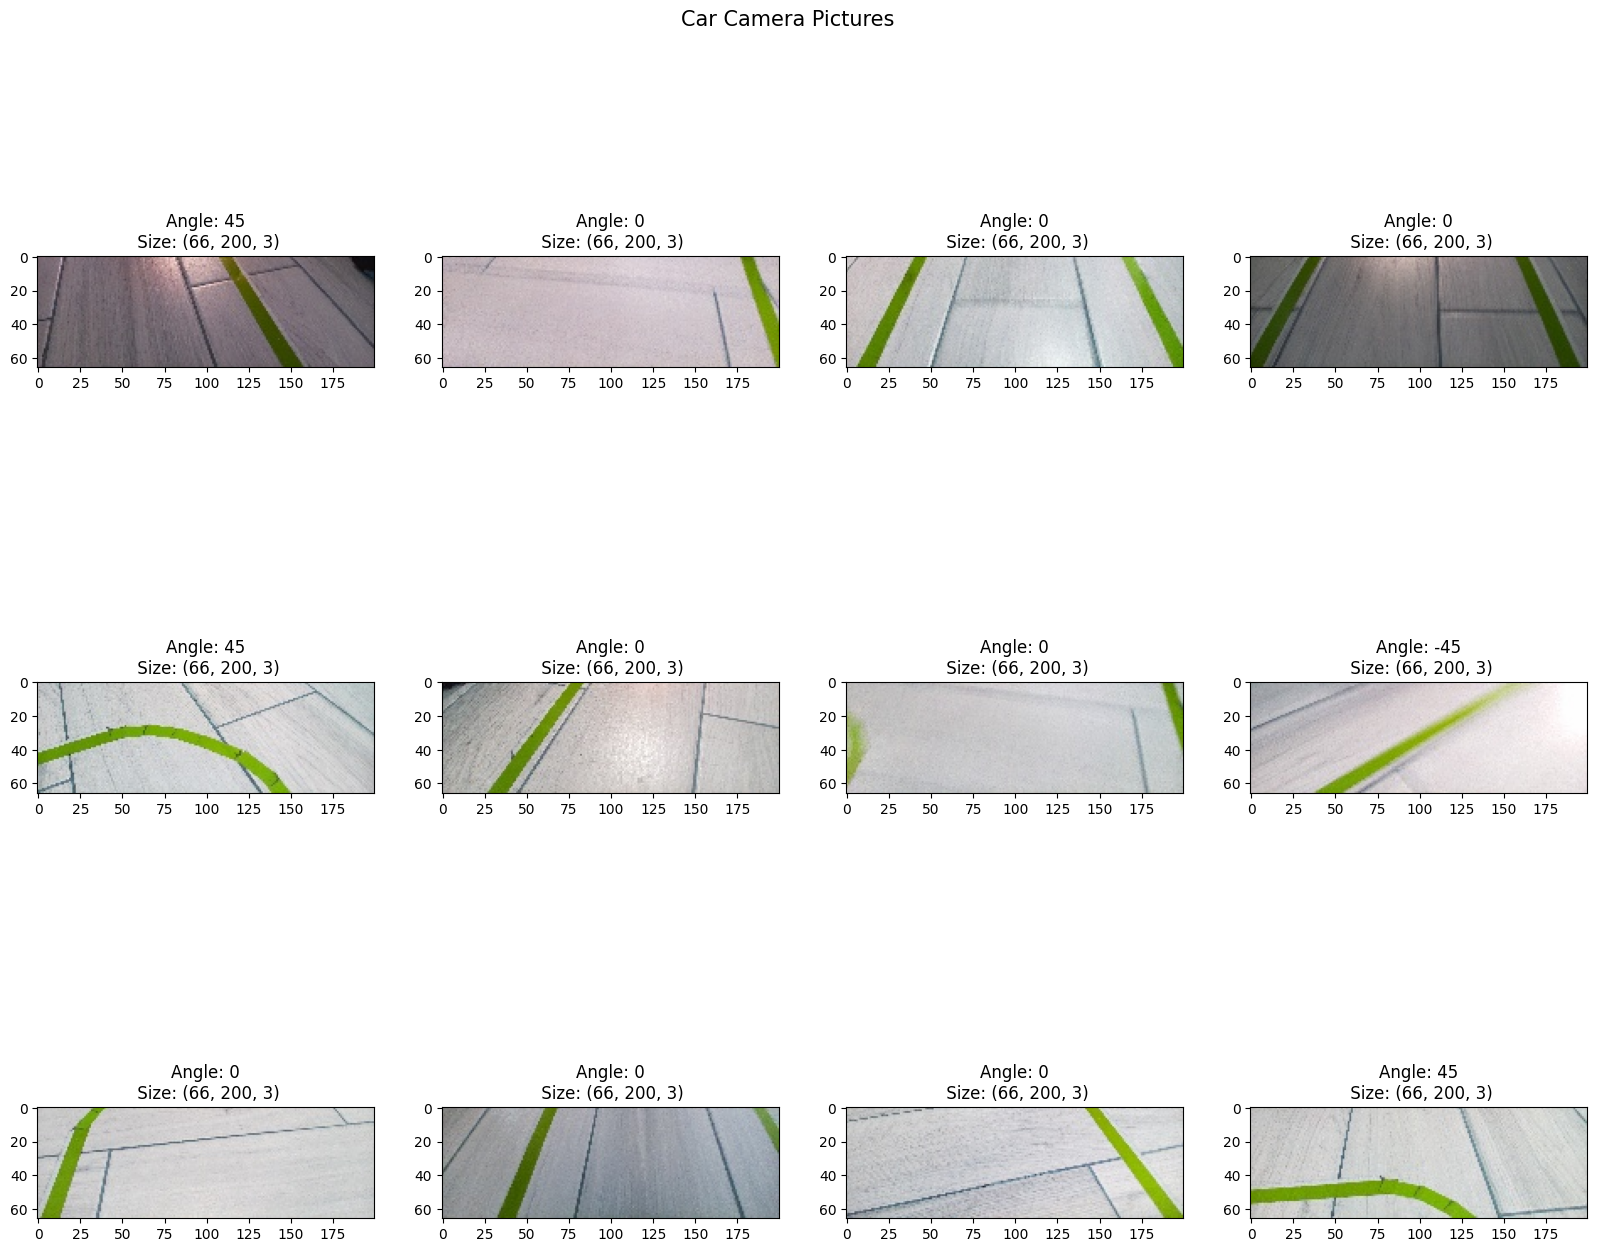

In [ ]:
imgs_train_path = '/content/drive/MyDrive/ML/sdc/data_for_training/data/imgs_train'
df = pd.read_csv(log_file)

# Original format of the pictures
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Car Camera Pictures', fontsize=15)

for i in range(12):
  plt.subplot(3, 4, 1 + i)
  seed(i)
  random_image_index = np.random.randint(0, len(df))
  np_image = imread(os.path.join(imgs_train_path, df.loc[random_image_index, 'frameName']))
  plt.imshow(np_image)
  plt.title('Angle: ' + str(df.loc[random_image_index, 'steering_angle']) + '\n Size: ' + str(np_image.shape))

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

### 4. Exploratory data analysis

#### 4.1 Distribution of steering angles

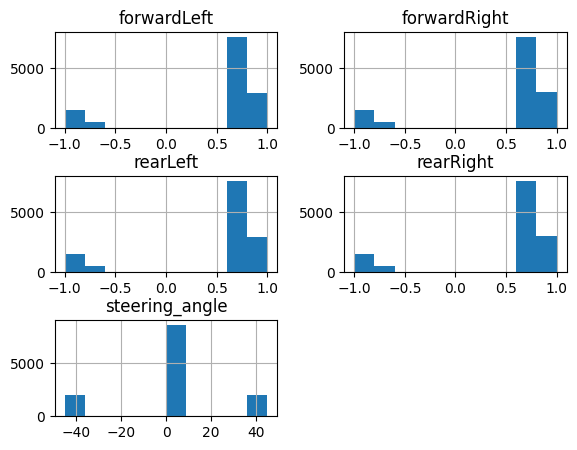

Angles from -45 to 45


In [ ]:
df.hist(bins=10)
plt.title('Distribution of Steering Angles')
# Adjust layout
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5, wspace=0.3)
plt.show()
print(f'Angles from '+str(min(df['steering_angle']))+' to '+str(max(df['steering_angle'])))

### 5. Splitting data

In [ ]:
# Split into train, test and validation sets
# Update 'frameName' to include the root path
df['frameName'] = df['frameName'].apply(lambda x: os.path.join(imgs_train_path, x))
X = df['frameName'].values
y = df['steering_angle'].values

# Splitting the data into training and temp sets, and then splitting the temp set further into validation and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42) # 80-20 split for training and temporary set
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # Splitting the 20% temporary set equally into validation and test sets

print(f"Training data: ({len(X_train)}, {len(y_train)}) samples")
print(f"Validation data: ({len(X_valid)}, {len(y_valid)}) samples")
print(f"Test data: ({len(X_test)}, {len(y_test)}) samples")

Training data: (10093, 10093) samples
Validation data: (1262, 1262) samples
Test data: (1262, 1262) samples


In [ ]:
# Map angles to class labels
label_mapping = {0: 0, -45: 1, 45: 2} # Forward, right, left
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

y_train = np.array([label_mapping[angle] for angle in y_train])
y_valid = np.array([label_mapping[angle] for angle in y_valid])
y_test = np.array([label_mapping[angle] for angle in y_test])

In [ ]:
# Separate the data by class
X_train_paths_forward = X_train[y_train == 0]
y_train_forward = y_train[y_train == 0]

X_train_paths_right = X_train[y_train == 1]
y_train_right = y_train[y_train == 1]

X_train_paths_left = X_train[y_train == 2]
y_train_left = y_train[y_train == 2]

In [ ]:
from sklearn.utils import resample

# Determine the target sample size (e.g., average size of minority classes)
n_samples = min(len(X_train_paths_right), len(X_train_paths_left), len(X_train_paths_forward))

# Downsample 'forward' class
X_train_forward_downsampled, y_train_forward_downsampled = resample(
    X_train_paths_forward, y_train_forward,
    replace=False,   # Sample without replacement
    n_samples=n_samples,
    random_state=42  # For reproducibility
)
print(X_train_forward_downsampled.shape)

(1602,)


In [ ]:
# Combine the downsampled 'forward' class with 'right' and 'left' classes
X_train_balanced = np.concatenate((X_train_forward_downsampled, X_train_paths_right, X_train_paths_left), axis=0)
y_train_balanced = np.concatenate((y_train_forward_downsampled, y_train_right, y_train_left), axis=0)

# Shuffle the combined dataset
from sklearn.utils import shuffle

X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
print(X_train_balanced.shape)

(4828,)


In [ ]:
# Convert labels to One-Hot Encoding
from tensorflow.keras.utils import to_categorical

num_classes = 3
y_train_one_hot = to_categorical(y_train_balanced, num_classes=num_classes)
y_valid_one_hot = to_categorical(y_valid, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)


In [ ]:
# Compute class weights
from sklearn.utils import class_weight

y_train_classes = np.argmax(y_train_one_hot, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Computed class weights:", class_weights_dict)

Computed class weights: {0: 1.0045776113191844, 1: 0.9909688013136289, 2: 1.0045776113191844}


In [ ]:
# def load_images(image_paths):
#     images = []
#     for frame_name in image_paths:
#         try:
#             img = Image.open(frame_name).convert('RGB')  # Ensure image is in RGB mode
#             img_array = np.array(img)
#             images.append(img_array)
#         except Exception as e:
#             print(f"Error loading image {frame_name}: {e}")
#     return np.array(images)

# # Load images with error handling
# X_train = load_images(X_train)
# X_valid = load_images(X_valid)
# X_test = load_images(X_test)

# print(X_train.shape, X_valid.shape, X_test.shape)

(6251, 66, 200, 3) (781, 66, 200, 3) (782, 66, 200, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# def load_image(path):
#     img = load_img(path, color_mode='rgb')  # Ensure images are in RGB format
#     img_array = img_to_array(img)  # Converts to NumPy array with shape (height, width, channels)
#     return img_array

def load_image(path):
    img = load_img(path, color_mode='rgb', target_size=(66, 200))
    img_array = img_to_array(img)
    return img_array

X_train = np.array([load_image(frame_name) for frame_name in X_train_balanced])
X_valid = np.array([load_image(frame_name) for frame_name in X_valid])
X_test = np.array([load_image(frame_name) for frame_name in X_test])
print(X_train.shape, X_valid.shape, X_test.shape)

(4828, 66, 200, 3) (1262, 66, 200, 3) (1262, 66, 200, 3)


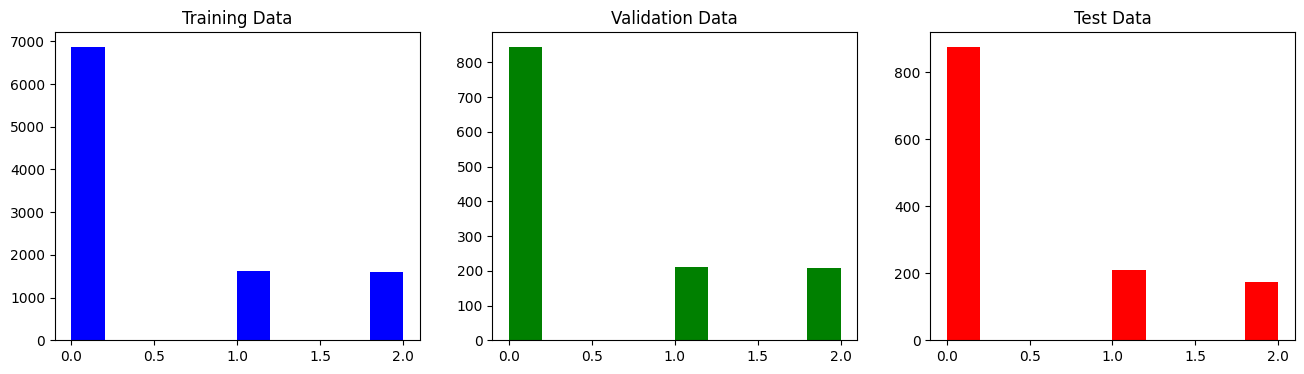

In [ ]:
# Distribution of steering angles for training, validation, and test sets
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
num_of_bins = 10

axes[0].hist(y_train, bins=num_of_bins, color='blue')
axes[0].set_title('Training Data')

axes[1].hist(y_valid, bins=num_of_bins, color='green')
axes[1].set_title('Validation Data')

axes[2].hist(y_test, bins=num_of_bins, color='red')
axes[2].set_title('Test Data')

plt.show()

In [ ]:
# y_train = to_categorical(y_train, num_classes=4)
# y_valid = to_categorical(y_valid, num_classes=4)
# y_test = to_categorical(y_test, num_classes=4)

### 6. Prepocessing Image

In [ ]:
def preprocess_image(image):
  img = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) # Nvidia model said it is best to use YUV color space
  img = cv2.GaussianBlur(img, (3, 3), 0)
  #img = cv2.resize(img, (200, 66)) # Input image size (200, 66) Nvidia model
  img = img / 255 # Normalization
  return img

In [ ]:
# train_datagen = ImageDataGenerator(
#         preprocessing_function=(preprocess_image) # rescale=1/255, input image size (200,66) Nvidia model, YUV color space, GaussianBlur
# )
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    zoom_range=0, # I updated this, the originl is 0.1
    width_shift_range=0,
    height_shift_range=0,
    brightness_range=(0.5, 1.5),
    shear_range=0,
    rotation_range=0,
    fill_mode='nearest',
    horizontal_flip=False
)


test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image, rescale=None)

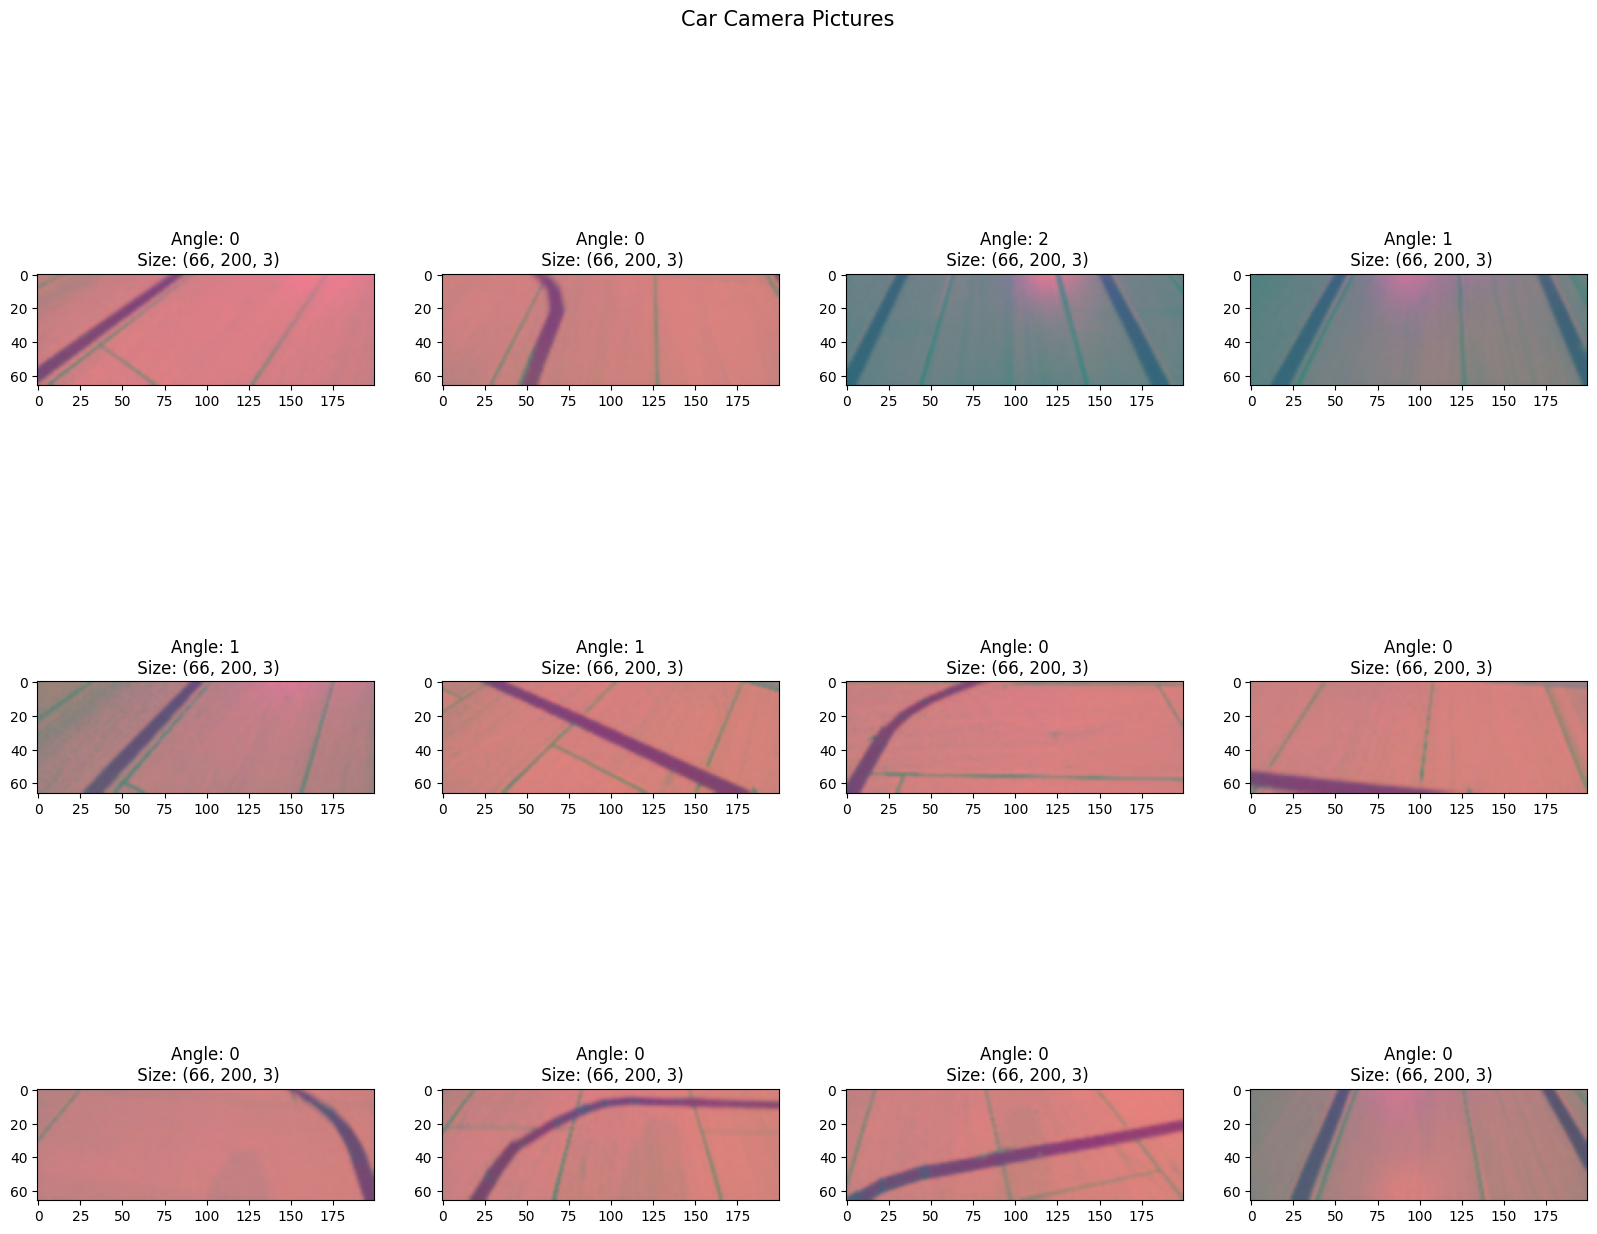

In [ ]:
# Show a few randomly preprocessed images
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Car Camera Pictures', fontsize=15)

for i in range(12):
  plt.subplot(3, 4, 1 + i)
  seed(i)
  rand_index = random.randint(0, len(X_train))
  image_path = df.at[rand_index, 'frameName']
  steering_angle = y_train[rand_index]
  image_orig = Image.open(image_path)
  image_proc = preprocess_image(np.array(image_orig))

  plt.imshow(image_proc)
  plt.title('Angle: ' + str(steering_angle) + '\n Size: ' + str(image_proc.shape))

### 7. Defining and training de model

#### 7.1 Defining model

Network architecture which consist of 9 layers, including a normalization layer, 5 convolutional layers, and 3 fully connected layers. The input image is split into YUV planes and passed to the network.

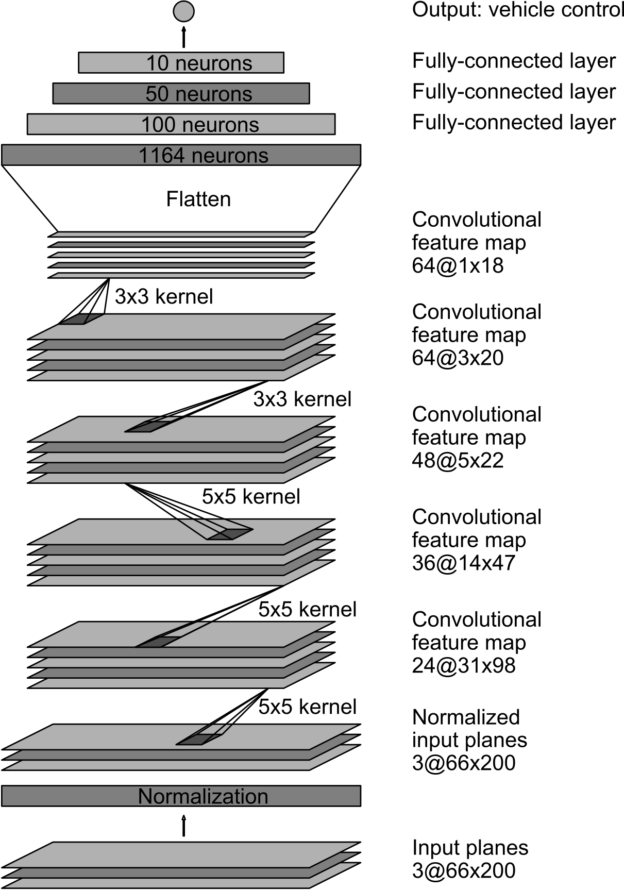

In [ ]:
def nvidia_model():

    model = Sequential(name='Nvidia_Model')

    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data

    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(BatchNormalization())

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.3)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    # Output layer for classification
    model.add(Dense(3, activation='softmax'))  # Three classes for left, forward, right,

    optimizer = Adam(learning_rate=0.001) # lr is learning rate
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# def enhanced_cnn_model(input_shape=(66, 200, 3), num_classes=3):
#     model = Sequential()

#     # First Convolutional Block
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Second Convolutional Block
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Third Convolutional Block
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Fully Connected Layers
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))  # Output layer

#     #optimizer = Adam(learning_rate=0.001) # lr is learning rate

#     # Compile
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# # Instantiate the updated model
# model = enhanced_cnn_model()
# model.summary()


In [ ]:
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# def transfer_learning_model(input_shape=(66, 200, 3), num_classes=3):
#     base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
#     base_model.trainable = False  # Freeze pre-trained layers

#     # Custom classification head
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     predictions = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=predictions)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# model = transfer_learning_model()
# model.summary()

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)                   │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 31, 98, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 14, 47, 36)          │             144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 5, 22, 48)           │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 3, 20, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 3, 20, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 3, 20, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 1, 18, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 1, 18, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,185 (989.00 KB)

 Trainable params: 252,713 (987.16 KB)

 Non-trainable params: 472 (1.84 KB)

None


In [ ]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard

output_dir = 'trained_models/end_to_end'
# clean up log folder for tensorboard
log_dir_root = f'{output_dir}/logs/'

In [ ]:
# this block prevents the training from starting if we Run All
# DO_NOT_RUN_ALL

#### 7.1 Training and saving model

In [ ]:
# Callbacks

# Saves the model weights after each epoch if the validation loss decrease
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(output_dir,'lane_navigation_check.keras'), verbose=1, save_best_only=True)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=30,
                           restore_best_weights=True,
                           mode='min')

plot_loss = PlotLossesKerasTF()

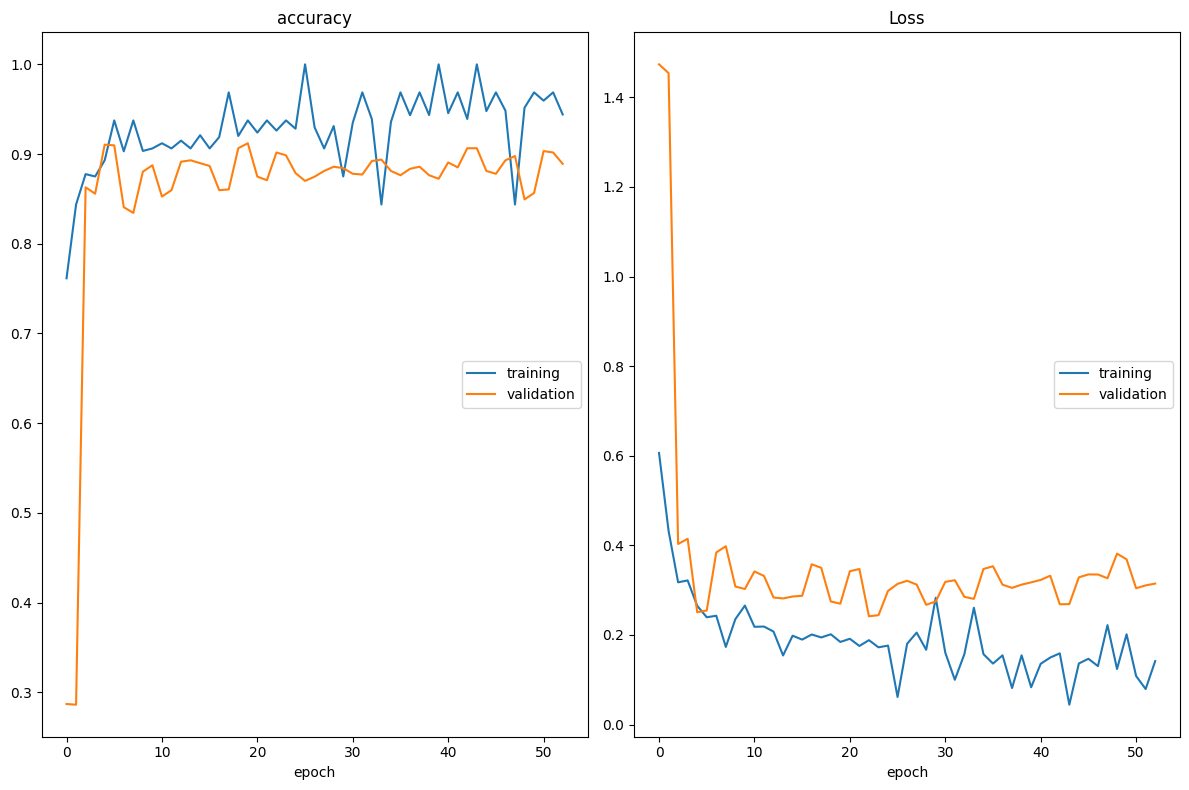

accuracy
	training         	 (min:    0.761, max:    1.000, cur:    0.944)
	validation       	 (min:    0.286, max:    0.912, cur:    0.889)
Loss
	training         	 (min:    0.044, max:    0.606, cur:    0.142)
	validation       	 (min:    0.242, max:    1.474, cur:    0.315)
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.9470 - loss: 0.1343 - val_accuracy: 0.8891 - val_loss: 0.3146
lane nav train finished. val_loss from 1.5 to 0.3


In [ ]:
batch_size = 32
history = model.fit(train_datagen.flow(X_train, y_train_one_hot, batch_size=batch_size),
                    steps_per_epoch = int(len(X_train)/batch_size),
                    epochs=100,
                    validation_data=test_datagen.flow(X_valid, y_valid_one_hot, batch_size=batch_size),
                    #validation_steps= int(len(X_valid)/batch_size),
                    verbose=1,
                    shuffle=True,
                    class_weight=class_weights_dict,
                    callbacks=[checkpoint_callback, early_stop, plot_loss])

# Always save model output as soon as model finishes training
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)
model.save(model_path)


date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
print("lane nav train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))

In [ ]:
history

In [ ]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

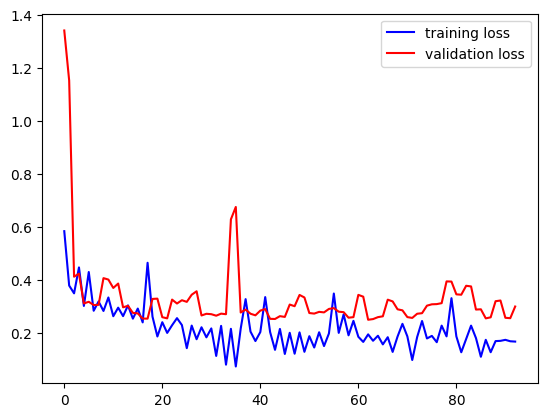

In [ ]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

### 8. Evaluate Model

In [ ]:
 model = tf.keras.models.load_model(model_path)

In [ ]:
# Step 1: Ensure batch_size is set to the length of X_test
batch_size = len(X_test)

# Step 1a: Apply preprocessing to X_test manually
X_test_preprocessed = np.array([preprocess_image(image) for image in X_test])

# Step 2: Recreate test_gen with the full batch_size
test_gen = test_datagen.flow(X_test, y_test_one_hot, batch_size=batch_size, shuffle=False)

# Step 3: Get images and labels from test_gen
images_from_gen, labels_from_gen = next(test_gen)

# Step 4: Convert images to the same data type
X_test_preprocessed = X_test_preprocessed.astype('float32')
images_from_gen = images_from_gen.astype('float32')

# Step 5: Compare images
images_equal = np.array_equal(X_test_preprocessed, images_from_gen)
print("Are the preprocessed images and images from test_gen equal?", images_equal)

# Step 6: Predict on both datasets
y_pred_gen = np.argmax(model.predict(images_from_gen), axis=1)
y_pred_manual = np.argmax(model.predict(X_test_preprocessed), axis=1)

# Step 7: Compare predictions
predictions_equal = np.array_equal(y_pred_gen, y_pred_manual)
print("Are predictions from test_gen and X_test_preprocessed equal?", predictions_equal)

# Step 8: Calculate accuracies
from sklearn.metrics import accuracy_score

# Accuracy using test_gen
y_true_gen = np.argmax(labels_from_gen, axis=1)
accuracy_gen = accuracy_score(y_true_gen, y_pred_gen)
print(f"Accuracy using test_gen: {accuracy_gen * 100:.2f}%")

# Accuracy using manual preprocessing
y_true_manual = np.argmax(y_test_one_hot, axis=1)
accuracy_manual = accuracy_score(y_true_manual, y_pred_manual)
print(f"Accuracy using manual preprocessing: {accuracy_manual * 100:.2f}%")

Are the preprocessed images and images from test_gen equal? True
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Are predictions from test_gen and X_test_preprocessed equal? True
Accuracy using test_gen: 90.65%
Accuracy using manual preprocessing: 90.65%


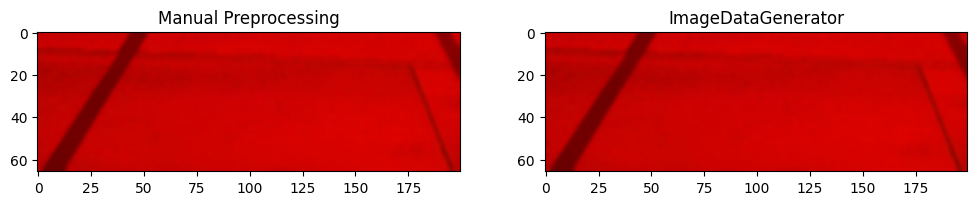

In [ ]:
import matplotlib.pyplot as plt

idx = 0  # Index of the image to compare
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(X_test_preprocessed[idx])
plt.title('Manual Preprocessing')

plt.subplot(1, 2, 2)
plt.imshow(images_from_gen[idx])
plt.title('ImageDataGenerator')

plt.show()

In [ ]:
print("X_test_preprocessed[idx] min:", X_test_preprocessed[idx].min(),
      "max:", X_test_preprocessed[idx].max(),
      "dtype:", X_test_preprocessed[idx].dtype)

print("images_from_gen[idx] min:", images_from_gen[idx].min(),
      "max:", images_from_gen[idx].max(),
      "dtype:", images_from_gen[idx].dtype)


X_test_preprocessed[idx] min: -0.25291115 max: 0.86952156 dtype: float32
images_from_gen[idx] min: -0.25291115 max: 0.86952156 dtype: float32


In [ ]:
cnn_performance = model.evaluate(test_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9073 - loss: 0.2322


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       876
           1       0.82      0.95      0.88       211
           2       0.79      0.87      0.83       175

    accuracy                           0.91      1262
   macro avg       0.86      0.91      0.88      1262
weighted avg       0.91      0.91      0.91      1262



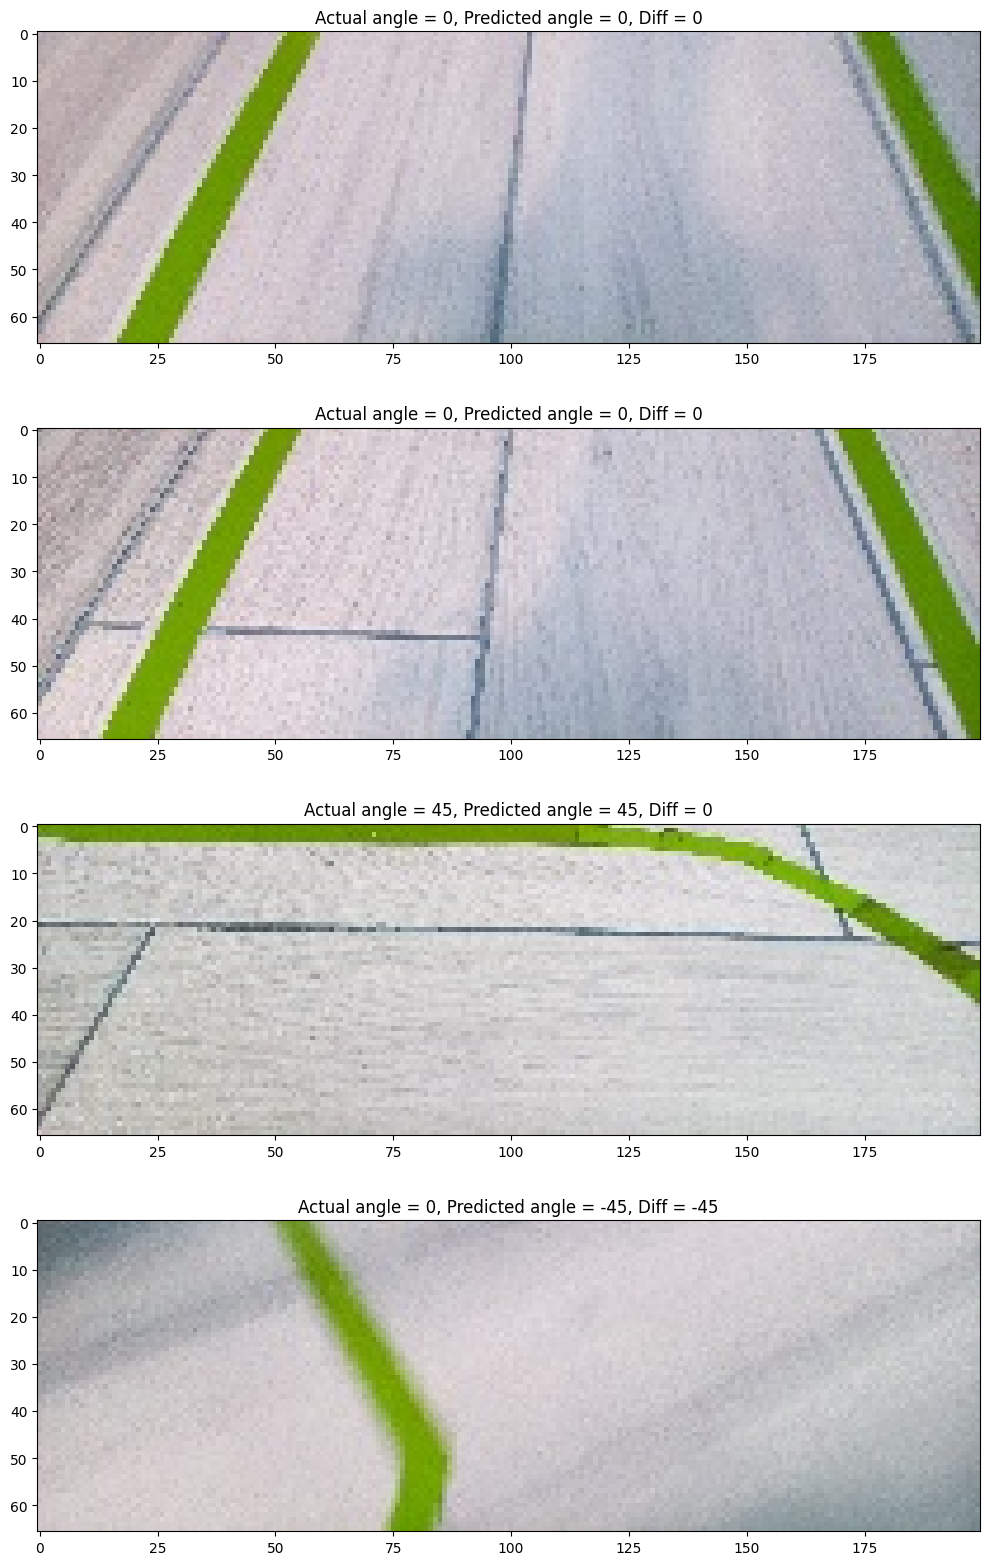

In [ ]:
import random
import matplotlib.pyplot as plt

# Ensure inverse_label_mapping is defined
inverse_label_mapping = {0: 0, 1: -45, 2: 45}

# Map back to original steering angles for predictions
y_pred_angles = [inverse_label_mapping[label] for label in y_pred_manual]

# Map back to original steering angles for actual test labels
y_test_labels = np.argmax(y_test_one_hot, axis=1)
y_test_angles = [inverse_label_mapping[label] for label in y_test_labels]

# Plotting the images and predictions
n_tests_show = 4
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))

for i in range(n_tests_show):
    j = random.randint(0, len(X_test) - 1)

    # Display the image
    axes[i].imshow(X_test[j].astype('uint8'))

    # Get the actual and predicted angles
    actual_angle = y_test_angles[j]
    predicted_angle = y_pred_angles[j]

    # Set the title with the actual, predicted, and difference
    axes[i].set_title(f"Actual angle = {actual_angle}, Predicted angle = {predicted_angle}, Diff = {predicted_angle - actual_angle}")

plt.tight_layout()
plt.show()